# Part B

## EM

In [1]:
options(warn=-1)
library(mvtnorm) # generates multivariate Gaussian sampels and calculate the densities
library(ggplot2) # plotting
library(reshape2) # data wrangling!
library(clusterGeneration) # generates the covariance matrices that we need for producing synthetic data.
library(tm)

Loading required package: MASS
Loading required package: NLP

Attaching package: 'NLP'

The following object is masked from 'package:ggplot2':

    annotate



II. EM define

In [2]:
hard_em <- function(N, K, D, data)
{
    # Setting the parameters:
    eta.max <- 100      # maximum number of iteratins
    epsilon <- 0.01  # termination threshold 

    # Initialzations:
    eta <- 1            # epoch counter
    terminate <- FALSE  # termination condition

    ## Ramdom cluster initialization:
    # set.seed(2) # save the random seed to make the results reproducble
    Phi.hat <- 1/K                          # assume all clusters have the same size (we will update this later on)
    Nk.hat <- matrix(N/K,nrow = K)          # refer to the above line!
    Mu.hat <- matrix(,nrow = K, ncol = D)
    
    for(k in 1:K)
    {
        Mu.hat[k,] = colSums(data[((k-1)*N/K+1):(k*N/K), ])
        Mu.hat[k,] = Mu.hat[k,] / sum(Mu.hat[k,] )
        
    }
    post <- matrix(,nrow=N, ncol=K)
    ### for each cluster k:

    # Build the GMM model
    Mu.hat.old <- Mu.hat # store the old estimated means
    # Main Loop
    while (!terminate)
    {   

        # E step:   
        for (k in 1:K){
            ## calculate the posterior based on the estimated means,covariance and cluster size:
            # post[,k] <- dmvnorm(data, Mu.hat[k,],  matrix(Sigma.hat[k,], ncol=D)) * Nk.hat[k]
            
            for(n in 1:N)
            {
                post[n,k] <- Nk.hat[k] / N
                
                for(d in 1:D)
                {
                    if(data[n,d] != 0)
                    {
                        post[n,k] = post[n,k] * Mu.hat[k,d]^data[n,d]
                    }
                } 
            }
        }
        # hard assignments:
        max.prob <- apply(post, 1, which.max) # for each point find the cluster with the maximum (estimated) probability
        post[] <- 0 # remove points from clusters with lower probabilites
        for(j in 1:length(max.prob))
        {
            post[j,max.prob[j]] <- 1 
        }
        
        # assign each point to the cluster with the highest probability
        # M step:
        for (k in 1:K)
        {
            ## recalculate the estimations:
            Nk.hat[k] <- sum(post[,k])        # the effective number of point in cluster k
            Phi.hat[k] <- sum(post[,k])/N     # the relative cluster size
            Mu.hat[k,] <- colSums(data[which(post[,k] == 1),])
            Mu.hat[k,] = Mu.hat[k,] / sum(Mu.hat[k,] )
        }

        
        eta <- eta+1

        # print(Mu.hat.old)
        # check the termination criteria
        terminate <- eta > eta.max | sum(abs(Mu.hat.old - Mu.hat)) <= epsilon
        
        # record the means (neccessary for checking the termination criteria)
        Mu.hat.old <- Mu.hat
        # print(terminate)
    }
    for (k in 1:K){
        ## calculate the posterior based on the estimated means,covariance and cluster size:
        # post[,k] <- dmvnorm(data, Mu.hat[k,],  matrix(Sigma.hat[k,], ncol=D)) * Nk.hat[k]
        
        for(n in 1:N)
        {
            post[n,k] <- Nk.hat[k] / N
            
            for(d in 1:D)
            {
                if(data[n,d] != 0)
                {
                    post[n,k] = post[n,k] * Mu.hat[k,d]^data[n,d]
                }
            } 
        }
    }
    # hard assignments:
    max.prob <- apply(post, 1, which.max) # for each point find the cluster with the maximum (estimated) probability

    print(Nk.hat)
    # That's it! Let see how many iterations we had:
    cat('maximum number of itterations:',eta,'\n')
    # return (Nk.hat, Mu.hat, Sigma.hat)
    return (max.prob )
}

In [4]:
soft_em <- function(N, K, D, data)
{

    # Setting the parameters:
    eta.max <- 100      # maximum number of iteratins
    epsilon <- 0.01  # termination threshold 

    # Initialzations:
    eta <- 1            # epoch counter
    terminate <- FALSE  # termination condition

    ## Ramdom cluster initialization:
    # set.seed(2) # save the random seed to make the results reproducble
    Phi.hat <- 1/K                          # assume all clusters have the same size (we will update this later on)
    Nk.hat <- matrix(N/K,nrow = K)          # refer to the above line!
    Mu.hat <- matrix(,nrow = K, ncol = D)
    
    for(k in 1:K)
    {
        Mu.hat[k,] = colSums(data[((k-1)*N/K+1):(k*N/K), ])
        Mu.hat[k,] = Mu.hat[k,] / sum(Mu.hat[k,] )
        
    }

    post <- matrix(,nrow=N, ncol=K)
    ### for each cluster k:

    # Build the GMM model
    Mu.hat.old <- Mu.hat # store the old estimated means
    # Main Loop
    while (!terminate)
    {
        # E step:   
        for (k in 1:K){
            ## calculate the posterior based on the estimated means,covariance and cluster size:
            # post[,k] <- dmvnorm(data, Mu.hat[k,],  matrix(Sigma.hat[k,], ncol=D)) * Nk.hat[k]
            
            for(n in 1:N)
            {
                post[n,k] <- Nk.hat[k] / N
                for(d in 1:D)
                {
                    if(data[n,d] != 0)
                    {
                        post[n,k] = post[n,k] * Mu.hat[k,d]^data[n,d]
                    }
                } 
            }
        }
        for(n in 1:N)
        {
            a = TRUE
            for(k in 1:K)
            {
                if(post[n,k] != 0)
                {
                    a = FALSE
                }
            }
            if(a)
            {
                for(k in 1:K)
                {
                    post[n,k] = 1
                }

            }
        }

        post <- post/rowSums(post) # normalization (to make sure post(k) is in [0,1] and sum(post)=1)
        
        #M step:
        for (k in 1:K)
        {
            ## recalculate the estimations:
            Nk.hat[k] <- sum(post[,k])        # the effective number of point in cluster k
            Phi.hat[k] <- sum(post[,k])/N     # the relative cluster size
            Mu.hat[k,] <- colSums(post[,k] *data)
            Mu.hat[k,] = Mu.hat[k,] / sum(Mu.hat[k,] )
        }
        eta <- eta+1
        
        # check the termination criteria
        terminate <- eta > eta.max | sum(abs(Mu.hat.old - Mu.hat)) <= epsilon
        
        # record the means (neccessary for checking the termination criteria)
        Mu.hat.old <- Mu.hat

    }

    for (k in 1:K){
        ## calculate the posterior based on the estimated means,covariance and cluster size:
        # post[,k] <- dmvnorm(data, Mu.hat[k,],  matrix(Sigma.hat[k,], ncol=D)) * Nk.hat[k]
        
        for(n in 1:N)
        {
            post[n,k] <- Nk.hat[k] / N
            
            for(d in 1:D)
            {
                if(data[n,d] != 0)
                {
                    post[n,k] = post[n,k] * Mu.hat[k,d]^data[n,d]
                }
            } 
        }
    }
    # hard assignments:
    max.prob <- apply(post, 1, which.max) # for each point find the cluster with the maximum (estimated) probability
    print(Nk.hat)
    # That's it! Let see how many iterations we had:
    cat('maximum number of itterations:',eta,'\n')
    return (max.prob)
}

III. load data and run code

In [5]:
## read the file (each line of the text file is one document)
text <- readLines('./TASK2B.txt')

## randomly selet some samples
index <- sample(length(text), 400)
text <- text[index]

## the terms before '\t' are the lables (the newsgroup names) and all the remaining text after '\t' are the actual documents
docs <- strsplit(text, '\t')
rm(text) # just free some memory!

In [6]:
# store the labels for evaluation
labels <-  unlist(lapply(docs, function(x) x[1]))

# store the unlabeled texts    
docs <- data.frame(doc_id = seq(1, length(labels)), text = unlist(lapply(docs, function(x) x[2])))

In [7]:
docs <- DataframeSource(docs)
docs <- Corpus(docs)
# Preprocessing:
docs <- tm_map(docs, removeWords, stopwords("english")) # remove stop words (the most common word in a language that can be find in any document)
docs <- tm_map(docs, removePunctuation) # remove pnctuation
docs <- tm_map(docs, stemDocument) # perform stemming (reducing inflected and derived words to their root form)
docs <- tm_map(docs, removeNumbers) # remove all numbers
docs <- tm_map(docs, stripWhitespace) # remove redundant spaces 

# Create a matrix which its rows are the documents and colomns are the words. 
## Each number in Document Term Matrix shows the frequency of a word (colomn header) in a particular document (row title)
dtm <- DocumentTermMatrix(docs)

## reduce the sparcity of out dtm
dtm <- removeSparseTerms(dtm, 0.90)

In [8]:
m <- as.matrix(dtm)
rownames(m) <- 1:nrow(m)

In [9]:
col1 = hard_em(dim(m)[1], 4, dim(m)[2], m)
col2 = soft_em(dim(m)[1], 4, dim(m)[2], m)

     [,1]
[1,]   61
[2,]  143
[3,]  147
[4,]   49
maximum number of itterations: 13 
          [,1]
[1,]  74.97359
[2,]  52.73963
[3,] 256.98845
[4,]  15.29833
maximum number of itterations: 18 


IV. PCA and plot picture

In [11]:
p.comp <- prcomp(m)   
length(which((col1 == col2) == TRUE))

[1] 228

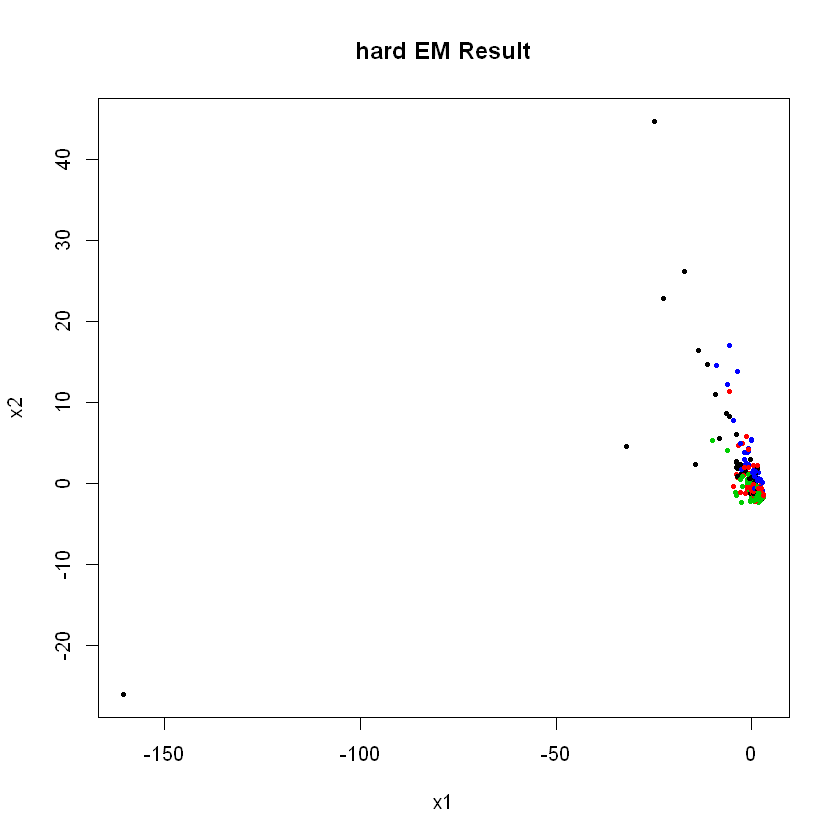

In [12]:
plot(p.comp$x, col=adjustcolor(col1, alpha=1), pch=16, main='hard EM Result', xlab = 'x1', ylab = 'x2', cex = 0.5)

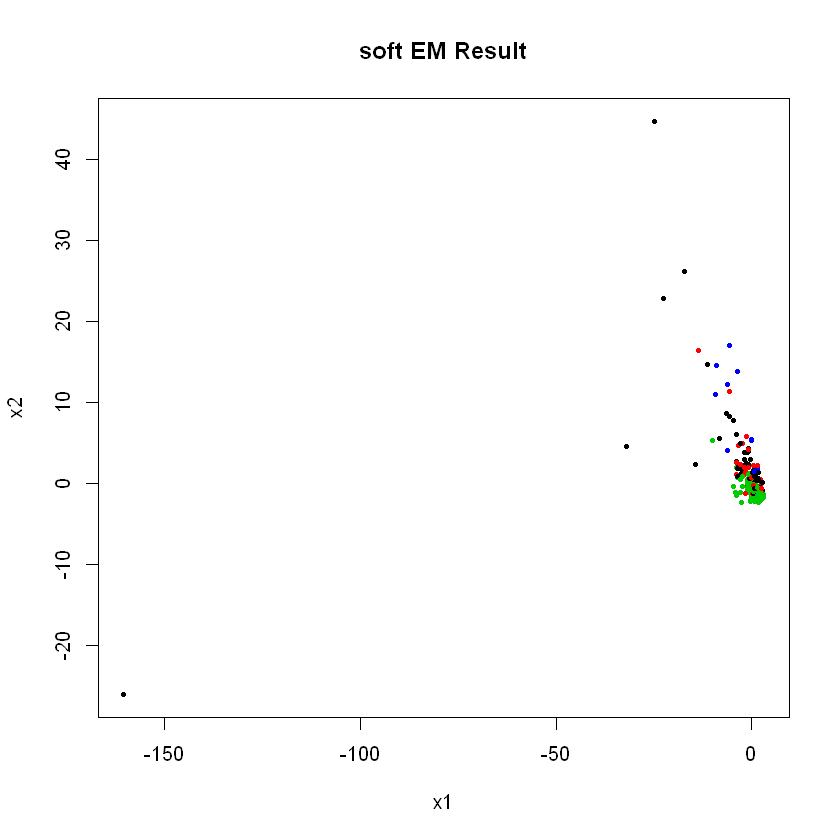

In [13]:
plot(p.comp$x, col=adjustcolor(col2, alpha=1), pch=16, main='soft EM Result', xlab = 'x1', ylab = 'x2', cex = 0.5)